In [1]:
import sys
sys.path.append("../scripts/")
from kf import *

In [10]:
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0, 0)
        self.cov = np.array([[1, 0], [0, 2]])
        
    def draw(self, ax, elems):
        if self.cov is None:
            return 
        
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:"+str(self.id), fontsize=10))
        
        e = sigma_ellipse(self.pos, self.cov, 3)
        elems.append(ax.add_patch(e))

In [7]:
class MapParticle(Particle):
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())

In [6]:
class FastSlam(Mcl):
    def __init__(self, envmap, init_pose, particle_num, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},
                distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(envmap, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
    
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

<IPython.core.display.Javascript object>


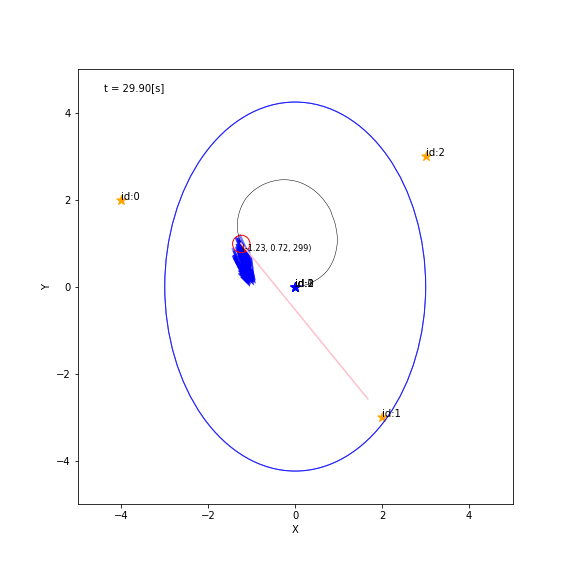

In [11]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=True)
    
    m = Map()
    for ln in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)
    
    init_pose = np.array([0, 0, 0]).T
    pf = FastSlam(m, init_pose, 100, len(m.landmarks))
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)
    
    world.draw()

trial()